In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data_gold_path = "source_data/gb_gold.json"
data_silver_path = "source_data/gb_silver.json"

with open(data_gold_path, "r") as file:
	data_gold = json.load(file)

with open(data_silver_path, "r") as file:
	data_silver = json.load(file)

# Check if there arekeys in common between the two datasets
common_keys = set(data_gold.keys()).intersection(data_silver.keys())
print("Number of common keys: ", len(common_keys))

# Merge the two datasets
data = {}
data.update(data_gold)
data.update(data_silver)

alphabetic, phonetic = [], []
for key, value in data.items():
	if isinstance(value, str):
		alphabetic.append(key)
		phonetic.append(value)

print("Number of entries: ", len(alphabetic))

df = pd.DataFrame({"alphabet": alphabetic, "phonetic": phonetic})
df.reset_index(inplace=True, drop=True)
df.head()

Number of common keys:  0
Number of entries:  194823


,alphabet,phonetic
0,'Merica,mˈɛɹɪkə
1,'Ndrangheta,ndɹaŋɡˈɛtə
2,'arf,ˈɑːf
3,'cause,kˈɒz
4,'cept,sˈɛpt


In [3]:
# List the characters used in the alphabet and phonetic data
alphabet_chars = set(' '.join(df["alphabet"].values))
phonetic_chars = set(' '.join(df["phonetic"].values))

print("Alphabet characters: ", alphabet_chars)
print("Phonetic characters: ", phonetic_chars)

print("Number of unique alphabet characters: ", len(alphabet_chars))
print("Number of unique phonetic characters: ", len(phonetic_chars))

Alphabet characters:  {'g', 'O', 'A', 'R', 'j', 'a', 'N', 'W', 'x', '.', 'K', 'k', 'C', 'd', 'P', 'Y', 'V', 'y', 'h', 'T', 'L', 'u', '-', 'v', 'o', 'm', 'H', 'E', 'X', 'z', 'n', 'D', 'G', 'B', 'e', 'l', "'", 'f', 'p', 'I', 'Q', 'M', 's', ' ', 'S', 'F', 'r', 'U', 'i', 'c', 't', 'J', 'Z', 'w', 'b', 'q'}
Phonetic characters:  {'ʒ', 'A', 'j', 'a', 'W', 'θ', 'ʊ', 'ᵊ', 'k', 'ɡ', 'd', 'Y', 'ŋ', 'h', 'ʌ', 'u', 'ʃ', 'ʧ', 'v', 'm', 'ɜ', 'ɑ', 'ð', 'z', 'n', 'l', 'ɹ', 'ə', 'f', 'p', 'Q', 'ˌ', 'I', 'ɔ', 's', 'ˈ', 'ɛ', ' ', 'i', 't', 'ɪ', 'w', 'ɒ', 'b', 'ː', 'ʤ'}
Number of unique alphabet characters:  56
Number of unique phonetic characters:  46


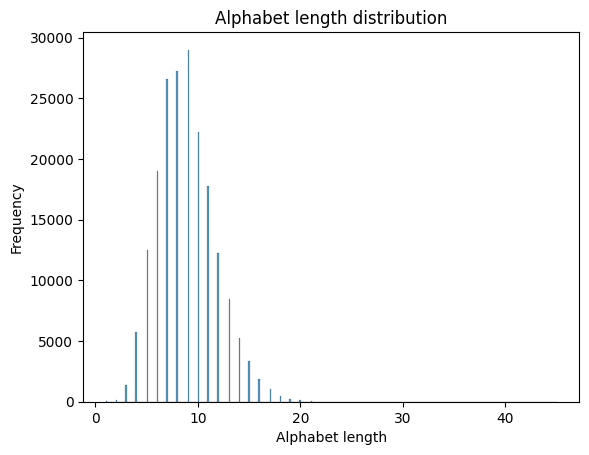

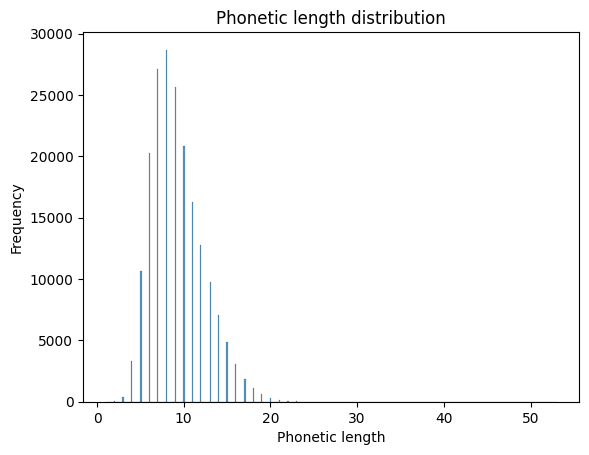

In [4]:
# Plot the length distribution of the alphabet and phonetic data

# Alphabet data
alphabet_len = df["alphabet"].apply(len)
sns.histplot(alphabet_len)
plt.xlabel("Alphabet length")
plt.ylabel("Frequency")
plt.title("Alphabet length distribution")
plt.show()

# Phonetic data
phonetic_len = df["phonetic"].apply(len)
sns.histplot(phonetic_len)
plt.xlabel("Phonetic length")
plt.ylabel("Frequency")
plt.title("Phonetic length distribution")
plt.show()

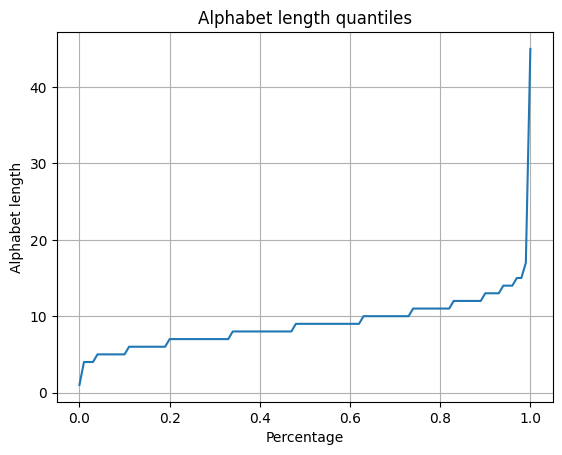

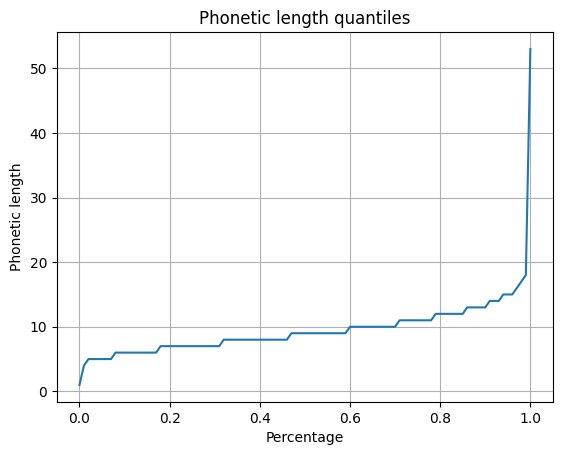

In [5]:
# Compute and plot quantiles of the alphabet and phonetic data lengths
percentages = np.arange(0, 1.01, 0.01)

# Alphabet data
alphabet_quantiles = alphabet_len.quantile(percentages)
plt.plot(percentages, alphabet_quantiles)
plt.xlabel("Percentage")
plt.ylabel("Alphabet length")
plt.title("Alphabet length quantiles")
plt.grid()
plt.show()

# Phonetic data
phonetic_quantiles = phonetic_len.quantile(percentages)
plt.plot(percentages, phonetic_quantiles)
plt.xlabel("Percentage")
plt.ylabel("Phonetic length")
plt.title("Phonetic length quantiles")
plt.grid()
plt.show()

In [6]:
# Only keep samples with alphabet and phonetic data lengths less or equal to 20
context_len = 20
offset = 2	# For the start and end tokens

# Note: No need for start and end tokens for the input data (alphabet)
df = df[(df["alphabet"].apply(len) <= context_len) & (df["phonetic"].apply(len) <= (context_len - offset))]
print("Number of samples after filtering: ", len(df))

Number of samples after filtering:  193623


In [8]:
# Create a tokenizer for the alphabet data and a tokenizer for the phonetic data

# Note: the "unknown" token is not actually used in the data, but it is added for completeness
special_tokens_enc_t2i = {"<PAD>": 0, "<UNK>": 1}
special_tokens_enc_i2t = {0: "<PAD>", 1: "<UNK>"}

# Note: the "target" token is used to 
special_tokens_dec_t2i = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<TARGET>": 3}
special_tokens_dec_i2t = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<TARGET>"}

enc_offset = len(special_tokens_enc_t2i)
dec_offset = len(special_tokens_dec_i2t)

# Alphabet tokenizer
alphabet_t2i = {char: idx + offset for idx, char in enumerate(alphabet_chars)}
alphabet_t2i.update(special_tokens_enc_t2i)

alphabet_i2t = {idx + offset: char for idx, char in enumerate(alphabet_chars)}
alphabet_i2t.update(special_tokens_enc_i2t)

# Phonetic tokenizer
phonetic_t2i = {char: idx + offset for idx, char in enumerate(phonetic_chars)}
phonetic_t2i.update(special_tokens_dec_t2i)

phonetic_i2t = {idx + offset: char for idx, char in enumerate(phonetic_chars)}
phonetic_i2t.update(special_tokens_dec_i2t)

# Display the tokenizers
print("Alphabet tokenizer:")
print(alphabet_t2i)
print(alphabet_i2t)

print("Phonetic tokenizer:")
print(phonetic_t2i)
print(phonetic_i2t)

# Save the tokenizers to a file
with open("tokenizers.json", "w") as file:
	json.dump({
		"supported_characters": list(alphabet_chars),
		"alphabet_t2i": alphabet_t2i,
		"alphabet_i2t": alphabet_i2t,
		"phoneme_t2i": phonetic_t2i,
		"phoneme_i2t": phonetic_i2t
	}, file)

print("Taille de l'alphabet : ", len(alphabet_t2i))
print("Taille du phonétique : ", len(phonetic_t2i))

Alphabet tokenizer:
{'g': 2, 'O': 3, 'A': 4, 'R': 5, 'j': 6, 'a': 7, 'N': 8, 'W': 9, 'x': 10, '.': 11, 'K': 12, 'k': 13, 'C': 14, 'd': 15, 'P': 16, 'Y': 17, 'V': 18, 'y': 19, 'h': 20, 'T': 21, 'L': 22, 'u': 23, '-': 24, 'v': 25, 'o': 26, 'm': 27, 'H': 28, 'E': 29, 'X': 30, 'z': 31, 'n': 32, 'D': 33, 'G': 34, 'B': 35, 'e': 36, 'l': 37, "'": 38, 'f': 39, 'p': 40, 'I': 41, 'Q': 42, 'M': 43, 's': 44, ' ': 45, 'S': 46, 'F': 47, 'r': 48, 'U': 49, 'i': 50, 'c': 51, 't': 52, 'J': 53, 'Z': 54, 'w': 55, 'b': 56, 'q': 57, '<PAD>': 0, '<UNK>': 1}
{2: 'g', 3: 'O', 4: 'A', 5: 'R', 6: 'j', 7: 'a', 8: 'N', 9: 'W', 10: 'x', 11: '.', 12: 'K', 13: 'k', 14: 'C', 15: 'd', 16: 'P', 17: 'Y', 18: 'V', 19: 'y', 20: 'h', 21: 'T', 22: 'L', 23: 'u', 24: '-', 25: 'v', 26: 'o', 27: 'm', 28: 'H', 29: 'E', 30: 'X', 31: 'z', 32: 'n', 33: 'D', 34: 'G', 35: 'B', 36: 'e', 37: 'l', 38: "'", 39: 'f', 40: 'p', 41: 'I', 42: 'Q', 43: 'M', 44: 's', 45: ' ', 46: 'S', 47: 'F', 48: 'r', 49: 'U', 50: 'i', 51: 'c', 52: 't', 53: 'J'

In [9]:
# Prepare the data for training
num_samples = len(df)  	# Number of samples in the dataframe
context_len = 20  		# Maximum length of the context

# Define special tokens
pad_token = "<PAD>"
sos_token = "<SOS>"
eos_token = "<EOS>"

# Initialize arrays for input (X), output (Y), and their lengths (L_x, L_y)
X = np.full((num_samples, context_len), alphabet_t2i[pad_token], dtype=np.int16)
Y = np.full((num_samples, context_len), phonetic_t2i[pad_token], dtype=np.int16)
L_x = np.zeros((num_samples, 1), dtype=np.int16)  # Lengths of the input sequences
L_y = np.zeros((num_samples, 1), dtype=np.int16)  # Lengths of the output sequences

# Set the start token for the output sequences
Y[:, 0] = phonetic_t2i[sos_token]

# Iterate over each row in the dataframe
for i, row in zip(range(num_samples), df.iterrows()):
	alphabet = row[1]["alphabet"]  # Alphabet sequence
	phonetic = row[1]["phonetic"]  # Phonetic sequence

	# Encode the alphabet sequence
	for j, char in enumerate(alphabet):
		X[i, j] = alphabet_t2i.get(char, alphabet_t2i["<UNK>"])  # Use <UNK> for unknown characters (here not used)

	# Encode the phonetic sequence
	for j, char in enumerate(phonetic):
		Y[i, j + 1] = phonetic_t2i[char]  # Skip the start token

	# Set the end token for the phonetic sequence
	Y[i, len(phonetic) + 1] = phonetic_t2i[eos_token]

	# Store the lengths of the sequences
	L_x[i] = len(alphabet)
	L_y[i] = len(phonetic) + 2  # Include the start and end tokens

In [11]:
# Part 2: prepare data for transformer training -> for each input sequence, n predictions are made
# Five arrays: X_enc (encoder input), X_dec (decoder input), Y_dec (decoder output), L_enc (encoder input length), L_dec (decoder input length)

target_prediction_count = 0
for l in L_y:
	target_prediction_count += l.item() - 1		# Exclude the start token

print("Number of target predictions: ", target_prediction_count)

# Fill X_enc and L_enc
X_enc = np.empty((target_prediction_count, context_len), dtype=np.int16)
L_enc = np.empty((target_prediction_count, 1), dtype=np.int16)

current_idx = 0
for x, l_x, l_y in zip(X, L_x, L_y):
	l_val = l_y.item() - 1	# Exclude the start token
	X_enc[current_idx:current_idx + l_val] = x
	L_enc[current_idx:current_idx + l_val] = l_x
	current_idx += l_val

# Save and delete X and L (to free up memory)
np.save("data/X_enc.npy", X_enc)
np.save("data/L_enc.npy", L_enc)
del X, X_enc, L_x, L_enc

# Fill X_dec, Y_dec, and L_dec
X_dec = np.full((target_prediction_count, context_len), phonetic_t2i[pad_token], dtype=np.int16)
Y_dec = np.full((target_prediction_count, 49), 0, dtype=np.int16)
L_dec = np.empty((target_prediction_count, 1), dtype=np.int16)

current_idx = 0
for y, l in zip(Y, L_y):
	l_val = l.item()
	for i in range(1, l_val):
		X_dec[current_idx, :i] = y[:i]
		X_dec[current_idx, i] = phonetic_t2i["<TARGET>"]

		target = y[i]
		Y_dec[current_idx, target] = 1

		L_dec[current_idx] = i
		current_idx += 1

# Save and delete Y and L (to free up memory)
np.save("data/X_dec.npy", X_dec)
np.save("data/Y_dec.npy", Y_dec)
np.save("data/L_dec.npy", L_dec)
del Y, X_dec, Y_dec, L_y, L_dec

Number of target predictions:  1973068
